# HDDM analysis of the 20Hz Data
Author: Julius Kricheldorff
Affiliation: Carl von Ossietzky University
Date: 04.03.2022

Import Neccessary packages:

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import hddm
print(hddm.__version__)
os.chdir(r"C:\Users\doex9445\Dateien\Julius\20Hz\Data\Extracted")
os.getcwd()

0.8.0


C:\Users\doex9445\AppData\Local\miniconda3\envs\DDM_space\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


'C:\\Users\\doex9445\\Dateien\\Julius\\20Hz\\Data\\Extracted'

Next we want to load the data. We will start first with the simplest task - simple reaction time task - for practice

In [4]:
data = hddm.load_csv('SimpleRT.csv')
data.head(10)

,Trial_Nr,Required_Response,nrbeding,Correct_Response,RT,Stimulus_Switch,Post_Error,eingfehler,Part_nr,run_nr,UPDRS,Stim,Stim_verb
0,1,right,39,0,0.343750,1,0,0,1,1,32,1,130Hz
1,2,left,39,1,0.703125,1,1,0,1,1,32,1,130Hz
2,3,right,38,0,0.281250,1,0,0,1,1,32,1,130Hz
3,4,right,37,1,0.515625,0,1,0,1,1,32,1,130Hz
4,5,right,36,1,0.609375,0,0,0,1,1,32,1,130Hz
5,6,right,35,1,0.625000,0,0,0,1,1,32,1,130Hz
6,7,left,38,1,0.625000,1,0,0,1,1,32,1,130Hz
7,8,right,34,1,0.703125,1,0,0,1,1,32,1,130Hz
8,9,left,37,1,0.625000,1,0,0,1,1,32,1,130Hz
9,10,left,36,1,0.890625,0,0,0,1,1,32,1,130Hz


Because the model takes specific variable names as input (I assume), we have to rename the subject, RT and accuracy columns.


In [3]:
data = data.rename(columns={"RT":"rt", "Part_nr":"subj_idx", "Correct_Response":"response"})
data.head(10)

,Trial_Nr,Required_Response,nrbeding,response,rt,Stimulus_Switch,Post_Error,eingfehler,subj_idx,run_nr,UPDRS,Stim,Stim_verb
0,1,right,39,0,0.343750,1,0,0,1,1,32,1,130Hz
1,2,left,39,1,0.703125,1,1,0,1,1,32,1,130Hz
2,3,right,38,0,0.281250,1,0,0,1,1,32,1,130Hz
3,4,right,37,1,0.515625,0,1,0,1,1,32,1,130Hz
4,5,right,36,1,0.609375,0,0,0,1,1,32,1,130Hz
5,6,right,35,1,0.625000,0,0,0,1,1,32,1,130Hz
6,7,left,38,1,0.625000,1,0,0,1,1,32,1,130Hz
7,8,right,34,1,0.703125,1,0,0,1,1,32,1,130Hz
8,9,left,37,1,0.625000,1,0,0,1,1,32,1,130Hz
9,10,left,36,1,0.890625,0,0,0,1,1,32,1,130Hz


Now we are ready to fit the first model. I think it makes sense to look at the whole data set.

In [7]:
md_srt_general = hddm.HDDM(data,
                          p_outlier = 0.05) # we say that 5% of our trials are outlier trials)
# find a good starting value
md_srt_general.find_starting_values()
#get samples and discard a couple as burn ins
md_srt_general.sample(2000, burn = 100)

C:\Users\doex9445\AppData\Local\miniconda3\envs\DDM_space\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 150.3 sec

Next let us summarize the posterior and print some stats

In [9]:
stats = md_srt_general.gen_stats()
stats[stats.index.isin(['a', 'v', 't'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.208031,0.248294,1.77647,2.04369,2.180836,2.349133,2.773724,0.010702
v,2.549184,0.426268,1.719636,2.279788,2.546145,2.813774,3.428557,0.011128
t,0.307192,0.022478,0.265713,0.293039,0.306406,0.319601,0.355952,0.000777


Okay, that looks already really nice, or at least like some summary results. Most importantly though, let us inspect the posteriors to see if the chains have converged. I expect that htis may not have been the case for the drift rate.

Plotting a
Plotting v
Plotting t


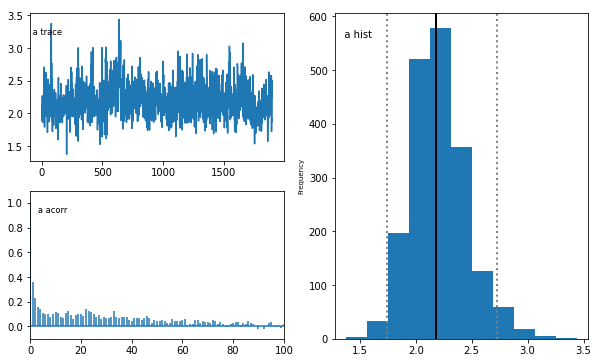

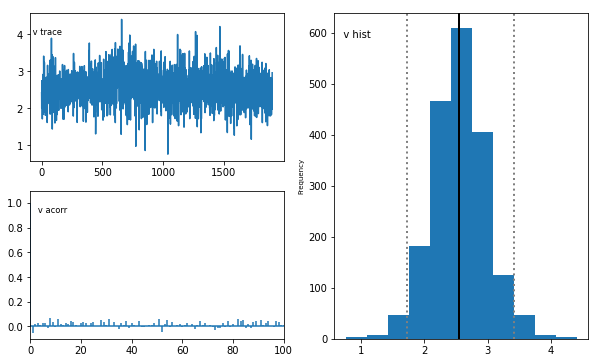

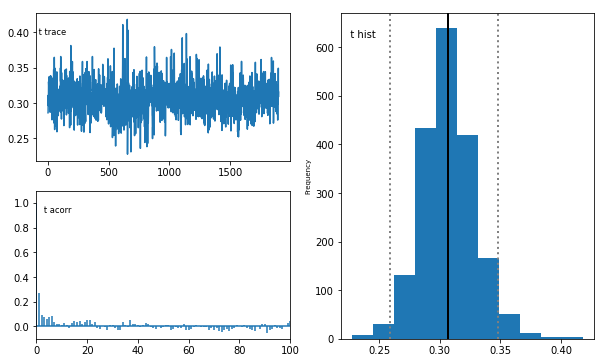

In [10]:
md_srt_general.plot_posteriors(['a', 'v', 't'])

let us look at the posterior predictive plots, to see if our model actually makes sense.

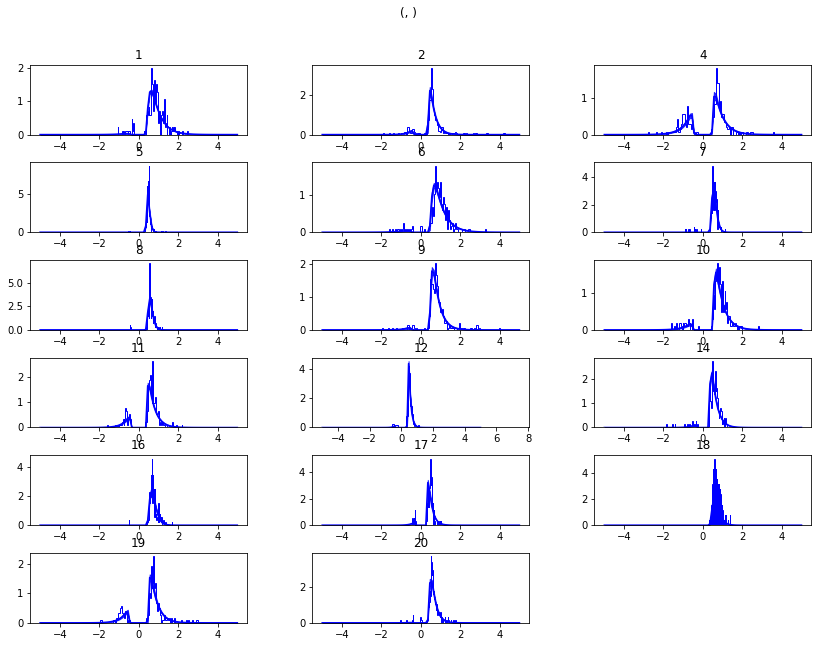

In [12]:
md_srt_general.plot_posterior_predictive(figsize=(14,10))

Okay, those look quite reasonable. Now let us see if we can model the drift rate by stimulus condition.

In [13]:
md_srt_stim = hddm.HDDMRegressor(data, 
                                 "v ~ C(Stim_verb, Treatment('OFF'))", # drift rate depends on stimulation condition
                                p_outlier = 0.05) # we say that 5% of our trials are outlier trials)
# find a good starting value
md_srt_stim.find_starting_values()
#get samples and discard a couple as burn ins
md_srt_stim.sample(2000, burn = 100)

Adding these covariates:
['v_Intercept', "v_C(Stim_verb, Treatment('OFF'))[T.130Hz]", "v_C(Stim_verb, Treatment('OFF'))[T.20Hz]"]


C:\Users\doex9445\AppData\Local\miniconda3\envs\DDM_space\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 584.6 sec

Next let me get the posteriors and plot the results

In [26]:
stats = md_srt_stim.gen_stats()
stats[stats.index.isin(['a', 't', 'v_Intercept', "v_C(Stim_verb, Treatment('OFF'))[T.20Hz]", "v_C(Stim_verb, Treatment('OFF'))[T.130Hz]"])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.158077,0.238535,1.75099,1.99467,2.138602,2.290758,2.684592,0.011633
t,0.308294,0.021763,0.26539,0.29511,0.308019,0.32126,0.354296,0.000865
v_Intercept,2.465053,0.41278,1.674897,2.192832,2.459733,2.733117,3.297009,0.010653
"v_C(Stim_verb, Treatment('OFF'))[T.130Hz]",0.100422,0.065879,-0.030277,0.05544,0.098895,0.145375,0.232135,0.00307
"v_C(Stim_verb, Treatment('OFF'))[T.20Hz]",0.082895,0.065226,-0.040662,0.037949,0.083072,0.126402,0.216539,0.003074


Next, let us plot the posteriors, first we extract them.

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects')

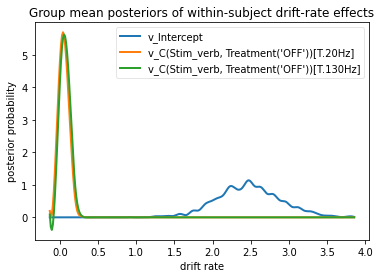

In [31]:
SOFF, S20Hz, S130Hz = md_srt_stim.nodes_db.loc[[
    'v_Intercept', 
    "v_C(Stim_verb, Treatment('OFF'))[T.20Hz]", 
    "v_C(Stim_verb, Treatment('OFF'))[T.130Hz]"
], 'node']
hddm.analyze.plot_posterior_nodes([SOFF, S20Hz, S130Hz])
plt.xlabel('drift rate')
plt.ylabel('posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects')

Let's try the same approach with variation in the threshold t

In [32]:
md_srt_stim_t = hddm.HDDMRegressor(data, 
                                   "t ~ C(Stim_verb, Treatment('OFF'))", # threshold depends on stimulation condition
                                  p_outlier = 0.05) # we say that 5% of our trials are outlier trials
# find a good starting value
md_srt_stim_t.find_starting_values()
#get samples and discard a couple as burn ins
md_srt_stim_t.sample(2000, burn = 100)

Adding these covariates:
['t_Intercept', "t_C(Stim_verb, Treatment('OFF'))[T.130Hz]", "t_C(Stim_verb, Treatment('OFF'))[T.20Hz]"]


C:\Users\doex9445\AppData\Local\miniconda3\envs\DDM_space\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 457.8 sec

In [34]:
stats = md_srt_stim_t.gen_stats()
stats[stats.index.isin(['a', 't', 't_Intercept', "t_C(Stim_verb, Treatment('OFF'))[T.20Hz]", "t_C(Stim_verb, Treatment('OFF'))[T.130Hz]"])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.167038,0.238479,1.769715,2.001887,2.146197,2.308861,2.697064,0.010589
t_Intercept,0.305361,0.019839,0.265537,0.29366,0.304686,0.317728,0.344365,0.000712
"t_C(Stim_verb, Treatment('OFF'))[T.130Hz]",-0.006096,0.004618,-0.015668,-0.009137,-0.006098,-0.002916,0.002607,0.000212
"t_C(Stim_verb, Treatment('OFF'))[T.20Hz]",0.014314,0.004102,0.006337,0.011644,0.014249,0.017161,0.022364,0.000191


Text(0.5, 1.0, 'Group mean posteriors of within-subject decision threshold effects')

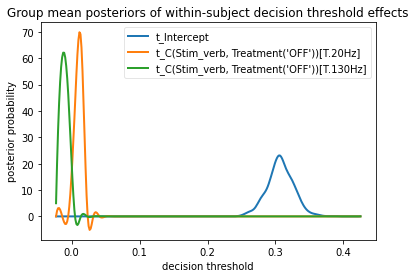

In [35]:
SOFF, S20Hz, S130Hz = md_srt_stim_t.nodes_db.loc[[
    't_Intercept', 
    "t_C(Stim_verb, Treatment('OFF'))[T.20Hz]", 
    "t_C(Stim_verb, Treatment('OFF'))[T.130Hz]"
], 'node']
hddm.analyze.plot_posterior_nodes([SOFF, S20Hz, S130Hz])
plt.xlabel('decision threshold')
plt.ylabel('posterior probability')
plt.title('Group mean posteriors of within-subject decision threshold effects')

That already looks a little intruiging... I think we will have to do some model comparisons, but we should keep this in mind. Next we should go back to the drawing board and simulate some data.
## Data Simulation and Parameter Recovery

In [8]:
def simulate_data(a, v, t, t_20, t_130, nr_trials = 100, nr_subs = 17):

    """
    Simulates the simple reaction time data
    """
    parametersOFF = {'a':a, 'v':v,'t':t}
    parameters20 = {'a':a, 'v':v, 't':t + t_20}
    parameters130 = {'a':a, 'v':v, 't':t + t_130}
    df_simOFF, params_simOFF = hddm.generate.gen_rand_data(params=parametersOFF, size=nr_trials, subjs = nr_subs, subj_noise=0)
    df_simOFF['condition'] = 'OFF'
    df_sim20, params_sim20 = hddm.generate.gen_rand_data(params=parameters20, size=nr_trials, subjs = nr_subs, subj_noise=0)
    df_sim20['condition'] = 'S20'
    df_sim130, params_sim130 = hddm.generate.gen_rand_data(params=parameters130, size=nr_trials, subjs = nr_subs, subj_noise=0)
    df_sim130['condition'] = 'S130'
    df_sim = pd.concat((df_simOFF, df_sim20, df_sim130))
    #df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    #df_sim['correct'] = df_sim['response'].astype(int)
    #df_sim['response'] = df_sim['bias_response'].astype(int)
    #df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    #df_sim['condition'] = condition
    #df_sim = df_sim.drop(columns=['bias_response'])
    return(df_sim)
    
# now simulate some data
sim_data = simulate_data(a = 2.2, 
                        v = 2.5,
                        t = 0.3,
                        t_20 = 0.02,
                        t_130 = 0)
# next let us model these differences to see if we can actually recover the parameter differences
md_srt_sim_t = hddm.HDDMRegressor(sim_data, 
                                   "t ~ C(condition, Treatment('OFF'))", # threshold depends on stimulation condition
                                  p_outlier = 0.05) # we say that 5% of our trials are outlier trials
# find a good starting value
md_srt_sim_t.find_starting_values()
#get samples and discard a couple as burn ins
md_srt_sim_t.sample(2000, burn = 100)


Adding these covariates:
['t_Intercept', "t_C(condition, Treatment('OFF'))[T.S130]", "t_C(condition, Treatment('OFF'))[T.S20]"]


C:\Users\doex9445\AppData\Local\miniconda3\envs\DDM_space\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 1026.4 sec

Get parameter estimates


In [9]:
stats = md_srt_sim_t.gen_stats()
stats[stats.index.isin(['a', 't', 't_Intercept', "t_C(condition, Treatment('OFF'))[T.20Hz]", "t_C(condition, Treatment('OFF'))[T.130Hz]"])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.260877,0.054065,2.170472,2.21744,2.256029,2.302239,2.359759,0.005261
t_Intercept,0.30294,0.005151,0.292775,0.299069,0.303254,0.307544,0.310465,0.000492


In [10]:
 md_srt_sim_t.gen_stats()
    

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.260877,0.054065,2.170472,2.21744,2.256029,2.302239,2.359759,0.005261
a_std,0.022007,0.016297,0.002414,0.009288,0.018606,0.030358,0.063494,0.001397
a_subj.0,2.256378,0.05866,2.157732,2.209111,2.253557,2.299871,2.365409,0.005359
a_subj.1,2.26673,0.058935,2.16545,2.218677,2.263917,2.310138,2.379301,0.005335
a_subj.2,2.257148,0.057249,2.160558,2.211653,2.254678,2.300896,2.362648,0.005218
a_subj.3,2.267903,0.057752,2.168488,2.221078,2.264174,2.311681,2.381113,0.005269
a_subj.4,2.255419,0.058372,2.155586,2.20978,2.252315,2.297583,2.363068,0.005352
a_subj.5,2.258712,0.05767,2.158376,2.211976,2.25697,2.301765,2.367142,0.005257
a_subj.6,2.266099,0.057756,2.166215,2.21901,2.261493,2.311008,2.380402,0.005229
a_subj.7,2.256445,0.057476,2.158885,2.209714,2.253435,2.298924,2.36283,0.005213
